<a href="https://colab.research.google.com/github/abduyea/Optimizing-Deep-Learning-Pipelines/blob/main/Optimizing_Deep_Learning_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




## Abdulfetah  Adem

# README: Optimizing Deep Learning Pipelines

## Objective
Train one baseline MLP and three optimized MLP models (Adam, SGD, RMSProp) to analyze how Dropout, Batch Normalization, and L2 Regularization affect accuracy and generalization on Sign Language MNIST.

## How to Run

1. **Clone repository**
   ```bash
   git clone https://github.com/abduyea/Optimizing-Deep-Learning-Pipelines.git
   cd Optimizing-Deep-Learning-Pipelines
   ```

2. **Open the Notebook**
   - Sign in with your Google account
   - Open the `.ipynb` file in Google Colab by clicking the Google Colab button at the top of the notebook

3. **Set Runtime**
   - Go to Runtime → Change runtime type
   - Select GPU (recommended) or CPU

4. **Mount Google Drive**
   - Load your dataset by mounting Drive:
   ```python
   from google.colab import drive
   drive.mount('/content/drive')
   ```

5. **Run the Notebook**
   - Run all cells from top to bottom, or
   - Run each cell manually as you follow the workflow


In [ ]:
# Install libraries and packages
%pip -q install -U seaborn scikit-learn black flake8
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import Sequential, optimizers, regularizers
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


##  Data Loading and Preprocessing

In [ ]:

# Mount Drive
from google.colab import drive

drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


### Load Dataset

Loading training and test CSV files from Google Drive.


In [ ]:

# data dir
DATA_DIR = "/content/drive/MyDrive/Sign Language MNIST"


In [ ]:
# CSV paths
train_path = os.path.join(DATA_DIR, "sign_mnist_train/sign_mnist_train.csv")
test_path = os.path.join(DATA_DIR, "sign_mnist_test/sign_mnist_test.csv")


### Preprocess Data

In [ ]:
# Check files
for p in (train_path, test_path):
    print(p, "→", os.path.isfile(p))


/content/drive/MyDrive/Sign Language MNIST/sign_mnist_train/sign_mnist_train.csv → True
/content/drive/MyDrive/Sign Language MNIST/sign_mnist_test/sign_mnist_test.csv → True


Loading data

In [ ]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train:", train_df.shape)
print("Test :", test_df.shape)

Train: (27455, 785)
Test : (7172, 785)


In [ ]:
# Raw labels
raw_train = train_df["label"].to_numpy()
raw_test = test_df["label"].to_numpy()


In [ ]:
# comput Classes
classes = np.sort(np.unique(np.concatenate((raw_train, raw_test))))
num_classes = len(classes)

print("Classes:", classes.tolist())
print("Count  :", num_classes)

assert num_classes == 24


Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Count  : 24


In [ ]:
# Label map
class_to_idx = {c: i for i, c in enumerate(classes)}
y_train = train_df["label"].map(class_to_idx).to_numpy()
y_test = test_df["label"].map(class_to_idx).to_numpy()

print("y_train:", int(y_train.min()), "→", int(y_train.max()))
print("y_test :", int(y_test.min()), "→", int(y_test.max()))

assert y_train.min() == 0 and y_train.max() == num_classes - 1
assert y_test.min() == 0 and y_test.max() == num_classes - 1


y_train: 0 → 23
y_test : 0 → 23


In [ ]:
# Normalize imgs
X_train_img = (
    train_df.drop(columns=["label"])
    .to_numpy()
    .reshape(-1, 28, 28) / 255.0
).astype("float32")

X_test_img = (
    test_df.drop(columns=["label"])
    .to_numpy()
    .reshape(-1, 28, 28) / 255.0
).astype("float32")


In [ ]:
# Flatten
X_train = X_train_img.reshape(-1, 784)
X_test = X_test_img.reshape(-1, 784)

print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("Range :", float(X_train_img.min()), "→", float(X_train_img.max()))
print("Classes:", num_classes)


X_train: (27455, 784) | X_test: (7172, 784)
Range : 0.0 → 1.0
Classes: 24


In [ ]:
# NaN check
print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in y_train:", np.isnan(y_train).sum())


NaNs in X_train: 0
NaNs in y_train: 0


##  Exploration and Visualization

In [ ]:
# Preview
train_df.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
# Preview
test_df.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [ ]:
# Stats
train_df.describe()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [ ]:
# Nulls
train_df.isnull().sum()
test_df.isnull().sum()


,0
label,0
pixel1,0
pixel2,0
pixel3,0
pixel4,0
...,...
pixel780,0
pixel781,0
pixel782,0
pixel783,0


In [ ]:
# Duplicates
train_df.duplicated().sum()
test_df.duplicated().sum()


np.int64(0)

In [ ]:
# Shapes
print(train_df.shape)
print(test_df.shape)


(27455, 785)
(7172, 785)


## Class Distribution

Visualizing the distribution of classes in the training set to check for class imbalance.


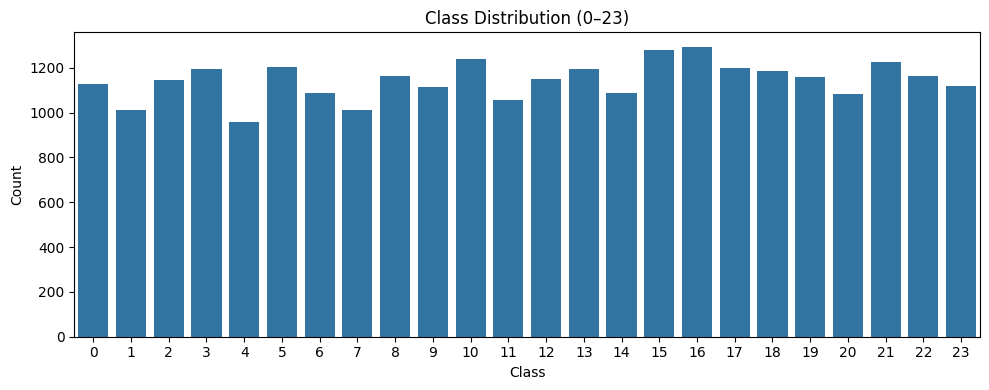

In [ ]:
# Class Distribution
plt.figure(figsize=(10, 4))
sns.countplot(x=y_train)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution (0–23)")
plt.tight_layout()
plt.show()


## Baseline Model

Training a simple baseline model without any optimization techniques.


In [ ]:
# Random sample indices
rng = np.random.default_rng(SEED)
idxs = rng.choice(len(X_train_img), 20, replace=False)


## Representative Images

Displaying 20 random sample images from the training set to visualize the dataset.


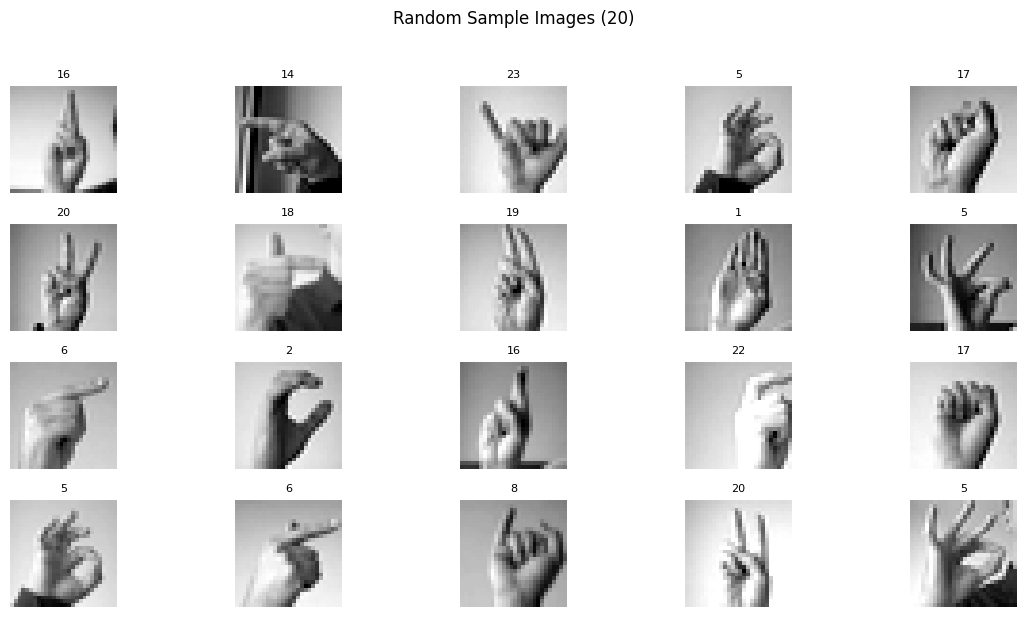

In [ ]:
# Plot 20 samples
plt.figure(figsize=(12, 6))

for i, idx in enumerate(idxs, 1):
    plt.subplot(4, 5, i)
    plt.imshow(X_train_img[idx], cmap="gray")
    plt.title(y_train[idx], fontsize=8)
    plt.axis("off")

plt.suptitle("Random Sample Images (20)", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# Accuracy/Loss plot
def plot_history(history, title="Training Curves"):
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, hist["accuracy"], label="Train Acc")
    if "val_accuracy" in hist:
        plt.plot(epochs, hist["val_accuracy"], label="Val Acc")
    plt.title(f"{title} — Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, hist["loss"], label="Train Loss")
    if "val_loss" in hist:
        plt.plot(epochs, hist["val_loss"], label="Val Loss")
    plt.title(f"{title} — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [ ]:
# Confusion matrix heatmap
def plot_confmat(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", cbar=True)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


## Baseline Model

Simple dense model with 3 layers (256 → 128 → 24 neurons) using Adam optimizer. No regularization techniques applied.


In [ ]:
# Classification report → DataFrame
def classif_report_df(y_true, y_pred) -> pd.DataFrame:
    rep = classification_report(
        y_true, y_pred, output_dict=True, zero_division=0
    )
    return pd.DataFrame(rep).transpose().round(3)


# Extract metrics for summary table
def pick_metrics(df, name):
    """Extract accuracy, macro F1, and weighted F1 from classification report."""
    acc = df.loc["accuracy", "precision"] if "accuracy" in df.index else None
    f1m = df.loc["macro avg", "f1-score"]
    f1w = df.loc["weighted avg", "f1-score"]
    return {"Model": name, "Accuracy": acc, "F1 (macro)": f1m, "F1 (weighted)": f1w}


In [ ]:
# Baseline model (256 → 128 → num_classes, Adam)
baseline = Sequential(
    [
        Dense(256, activation="relu", input_shape=(784,)),
        Dense(128, activation="relu"),
        Dense(num_classes, activation="softmax"),
    ],
)
baseline.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
baseline.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,952 (925.59 KB)

 Trainable params: 236,952 (925.59 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train baseline
history_baseline = baseline.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.2052 - loss: 2.6931 - val_accuracy: 0.5283 - val_loss: 1.5777
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5586 - loss: 1.4612 - val_accuracy: 0.6724 - val_loss: 1.1002
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6864 - loss: 1.0401 - val_accuracy: 0.7239 - val_loss: 0.8853
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7614 - loss: 0.8039 - val_accuracy: 0.7738 - val_loss: 0.7306
Epoch 5/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8151 - loss: 0.6378 - val_accuracy: 0.8374 - val_loss: 0.5705


In [ ]:
#  Evaluate baseline
bl_loss, bl_acc = baseline.evaluate(X_test, y_test, verbose=0)
print(f"Baseline — test_acc={bl_acc:.4f} | test_loss={bl_loss:.4f}")


Baseline — test_acc=0.6697 | test_loss=1.0822


### Baseline Evaluation

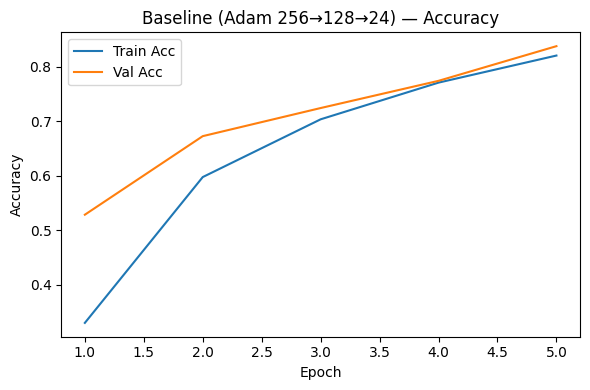

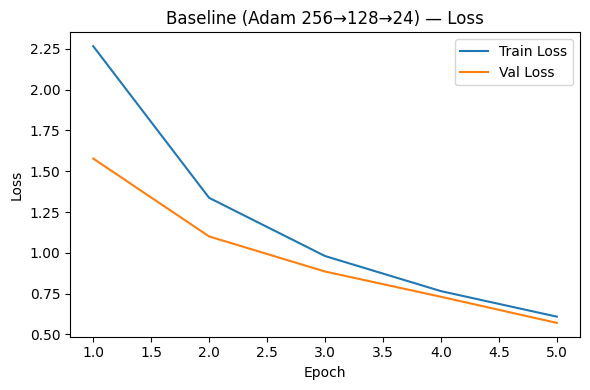

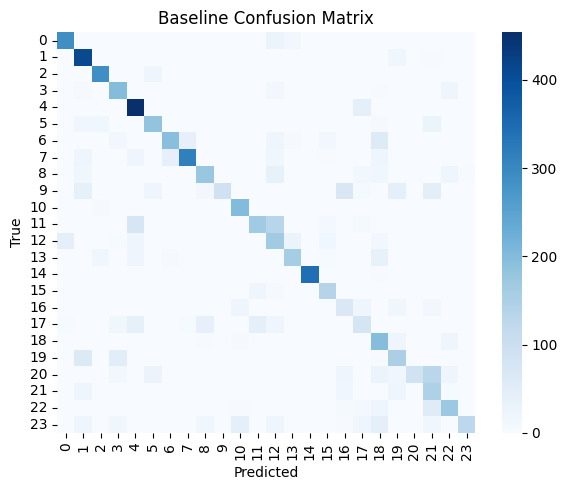

,precision,recall,f1-score,support
0,0.863,0.873,0.868,331.0
1,0.667,0.951,0.784,432.0
2,0.883,0.929,0.906,310.0
3,0.623,0.816,0.707,245.0
4,0.721,0.912,0.805,498.0


In [ ]:
#  Curves, confusion matrix, and report
plot_history(history_baseline, title="Baseline (Adam 256→128→24)")

y_pred_bl = baseline.predict(X_test, verbose=0).argmax(axis=1)
plot_confmat(y_test, y_pred_bl, title="Baseline Confusion Matrix")

rep_bl = classif_report_df(y_test, y_pred_bl)
rep_bl.head()


In [ ]:
# Optimized MLP builder
def build_mlp(
    optimizer_name: str = "adam",
    use_dropout: bool = False,
    use_bn: bool = False,
    use_l2: bool = False,
    l2_val: float = 1e-3,
):
    """512→256→num_classes MLP with optional Dropout/BN/L2."""
    reg = regularizers.l2(l2_val) if use_l2 else None

    layers = [
        Dense(512, activation="relu", kernel_regularizer=reg, input_shape=(784,)),
    ]
    if use_bn:
        layers.append(BatchNormalization())
    if use_dropout:
        layers.append(Dropout(0.3))

    layers.append(Dense(256, activation="relu", kernel_regularizer=reg))
    if use_bn:
        layers.append(BatchNormalization())
    if use_dropout:
        layers.append(Dropout(0.3))

    layers.append(Dense(num_classes, activation="softmax"))

    opt_name = optimizer_name.lower()
    opts = {
        "adam": optimizers.Adam(learning_rate=0.001),
        "sgd": optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
        "rmsprop": optimizers.RMSprop(learning_rate=0.001),
    }
    model = Sequential(layers)
    model.compile(
        optimizer=opts.get(opt_name, opts["adam"]),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [ ]:
# Train the 3 Optimized Models
EPOCHS = 10
BATCH = 128
VAL = 0.2

# Adam + Dropout + BatchNorm
opt_adam = build_mlp("adam", use_dropout=True, use_bn=True, use_l2=False)
hist_adam = opt_adam.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_split=VAL,
    verbose=1,
)

# SGD + L2
opt_sgd = build_mlp("sgd", use_dropout=False, use_bn=False, use_l2=True, l2_val=1e-3)
hist_sgd = opt_sgd.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_split=VAL,
    verbose=1,
)

# RMSProp + Dropout
opt_rms = build_mlp("rmsprop", use_dropout=True, use_bn=False, use_l2=False)
hist_rms = opt_rms.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_split=VAL,
    verbose=1,
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4654 - loss: 1.8947 - val_accuracy: 0.3243 - val_loss: 1.8488
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7998 - loss: 0.6387 - val_accuracy: 0.1865 - val_loss: 4.5459
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8217 - loss: 0.5613 - val_accuracy: 0.4107 - val_loss: 2.2244
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8168 - loss: 0.5449 - val_accuracy: 0.5107 - val_loss: 2.1130
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8440 - loss: 0.4662 - val_accuracy: 0.5862 - val_loss: 1.7525
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8543 - loss: 0.4416 - val_accuracy: 0.6496 - val_loss: 1.1818
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8706 - loss: 0.3815 - val_accuracy: 0.5467 - val_loss: 1.9065
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8579 - loss: 0.4218 - val_accuracy: 0

Optimized-Adam (DO+BN): test_acc=0.5346 | loss=2.2682
Optimized-SGD (L2): test_acc=0.7478 | loss=1.5530
Optimized-RMSProp (DO): test_acc=0.6392 | loss=1.0779


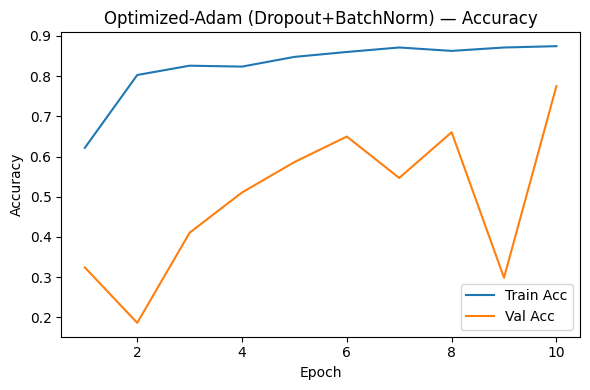

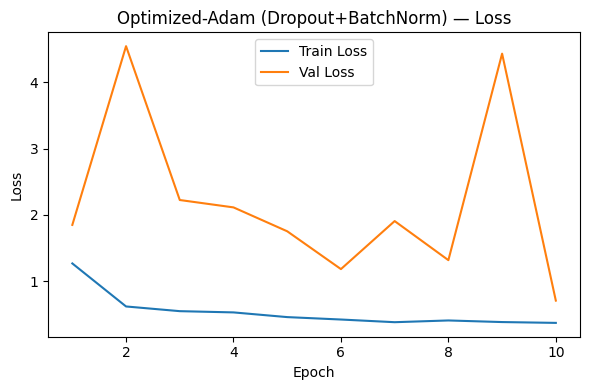

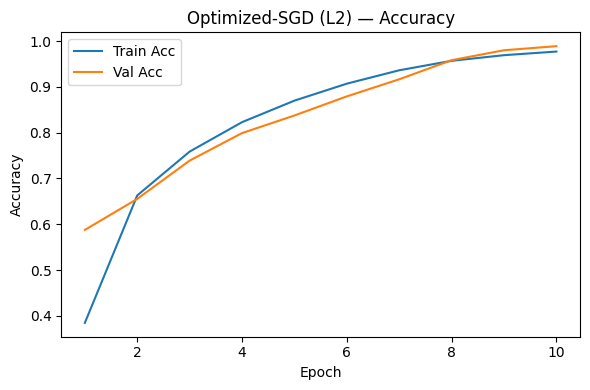

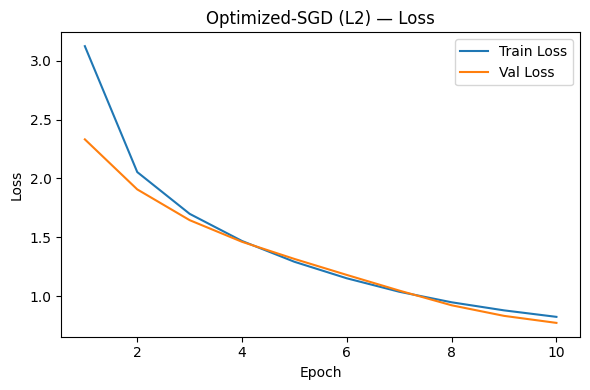

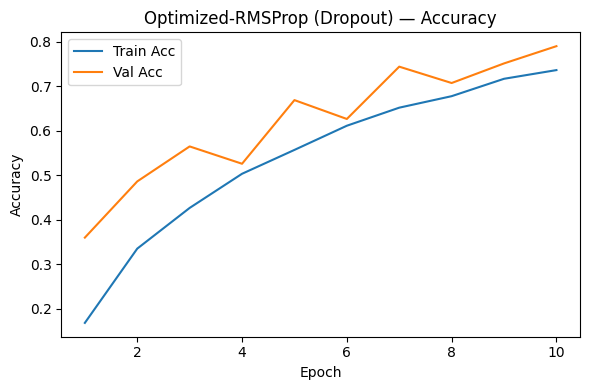

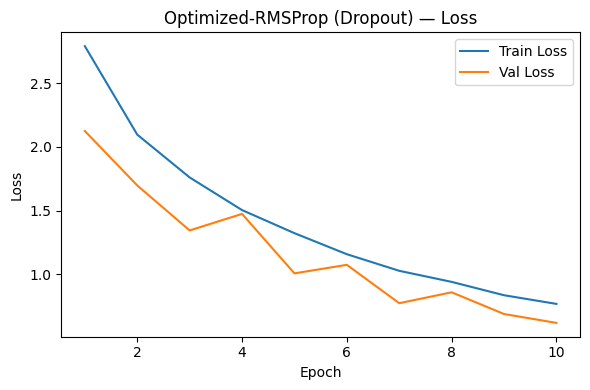

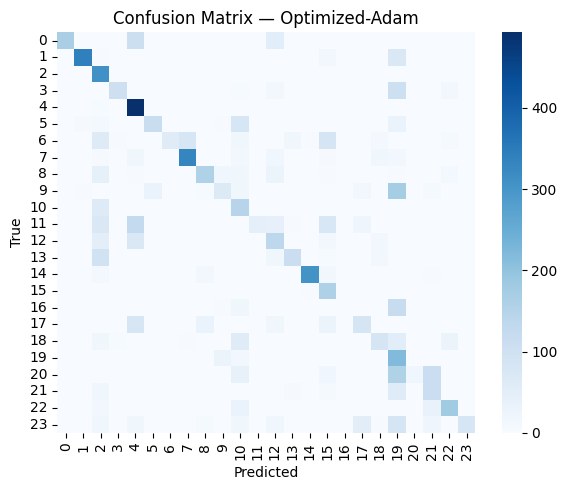

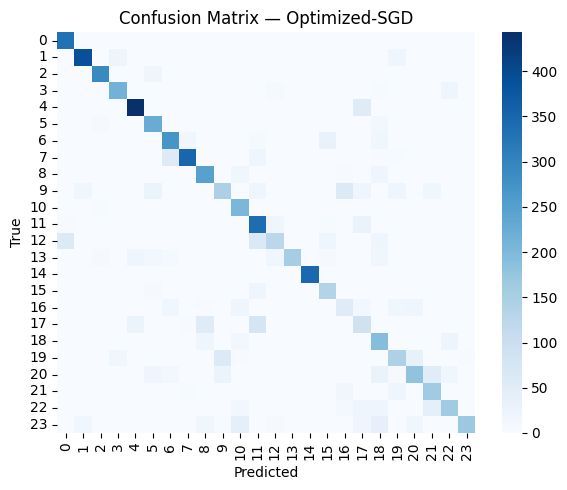

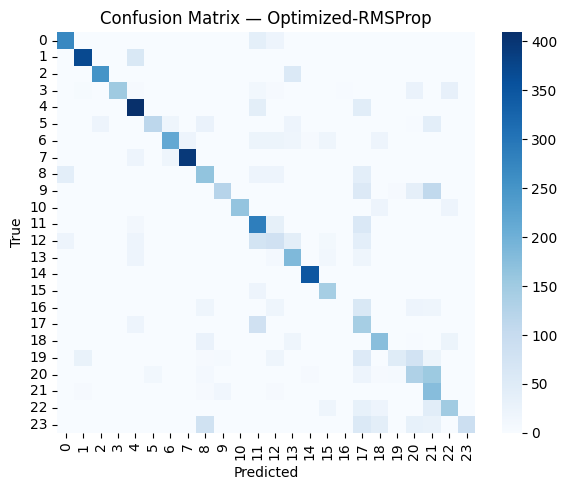

,precision,recall,f1-score,support
0,1.000,0.502,0.668,331.0
1,0.972,0.792,0.872,432.0
2,0.384,1.000,0.555,310.0
3,0.938,0.433,0.592,245.0
4,0.532,0.990,0.692,498.0


In [ ]:
#Evaluate Optimized Models
def quick_eval(model, name: str):
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{name}: test_acc={acc:.4f} | loss={loss:.4f}")
    return acc, loss

acc_adam, loss_adam = quick_eval(opt_adam, "Optimized-Adam (DO+BN)")
acc_sgd, loss_sgd = quick_eval(opt_sgd, "Optimized-SGD (L2)")
acc_rms, loss_rms = quick_eval(opt_rms, "Optimized-RMSProp (DO)")

# Curves
plot_history(hist_adam, title="Optimized-Adam (Dropout+BatchNorm)")
plot_history(hist_sgd, title="Optimized-SGD (L2)")
plot_history(hist_rms, title="Optimized-RMSProp (Dropout)")

# Predictions + reports
y_pred_adm = opt_adam.predict(X_test, verbose=0).argmax(axis=1)
y_pred_sgd = opt_sgd.predict(X_test, verbose=0).argmax(axis=1)
y_pred_rms = opt_rms.predict(X_test, verbose=0).argmax(axis=1)

plot_confmat(y_test, y_pred_adm, "Confusion Matrix — Optimized-Adam")
plot_confmat(y_test, y_pred_sgd, "Confusion Matrix — Optimized-SGD")
plot_confmat(y_test, y_pred_rms, "Confusion Matrix — Optimized-RMSProp")

rep_adm = classif_report_df(y_test, y_pred_adm)
rep_sgd = classif_report_df(y_test, y_pred_sgd)
rep_rms = classif_report_df(y_test, y_pred_rms)

rep_adm.head()


# Refactored Optimized Model evaluation uing decoder

Optimized-Adam (DO+BN): test_acc=0.5346 | loss=2.2682
Evaluation complete for Optimized-Adam (DO+BN)
Optimized-SGD (L2): test_acc=0.7478 | loss=1.5530
Evaluation complete for Optimized-SGD (L2)
Optimized-RMSProp (DO): test_acc=0.6392 | loss=1.0779
Evaluation complete for Optimized-RMSProp (DO)


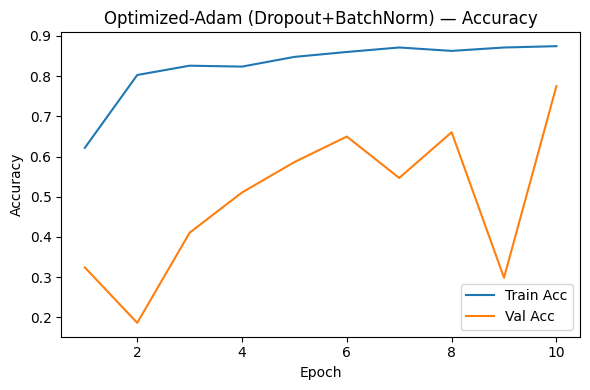

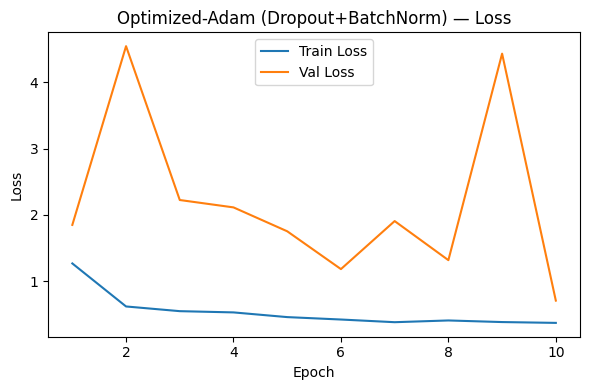

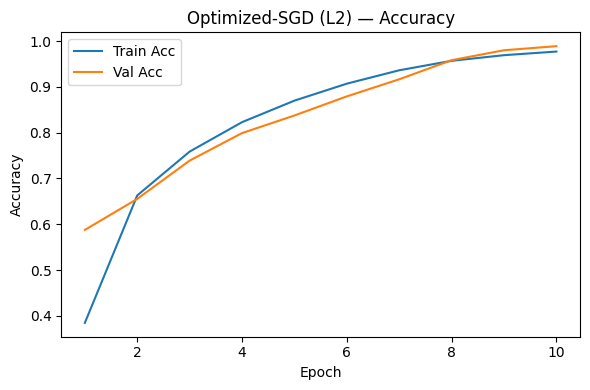

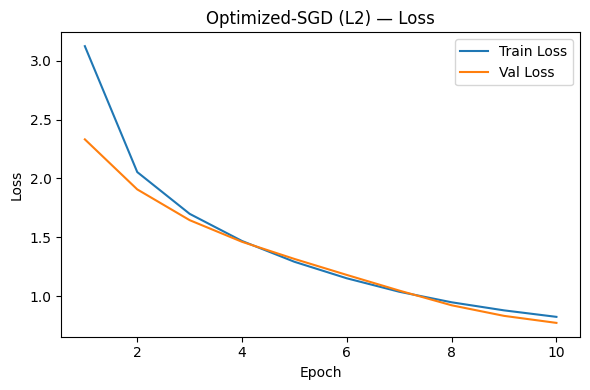

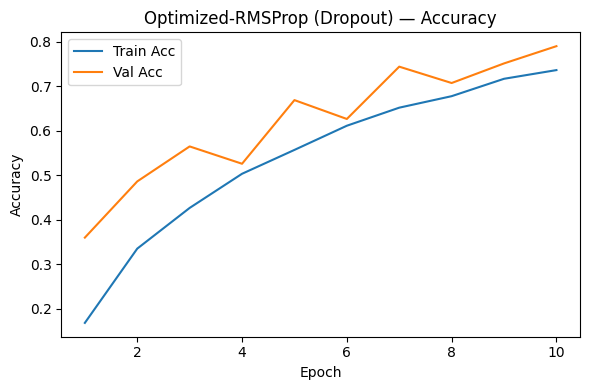

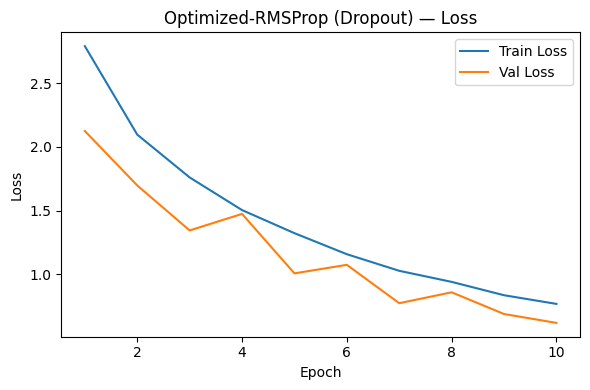

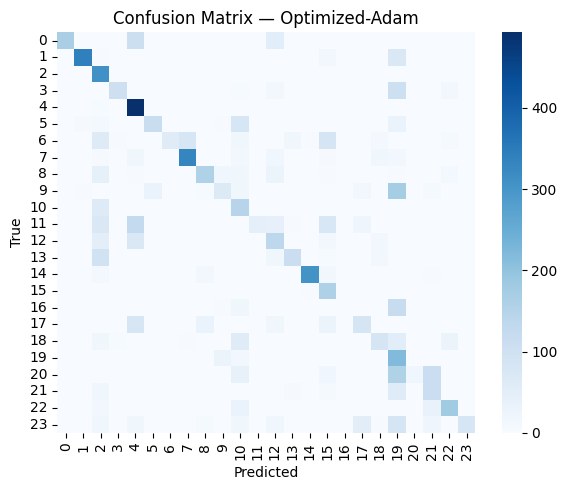

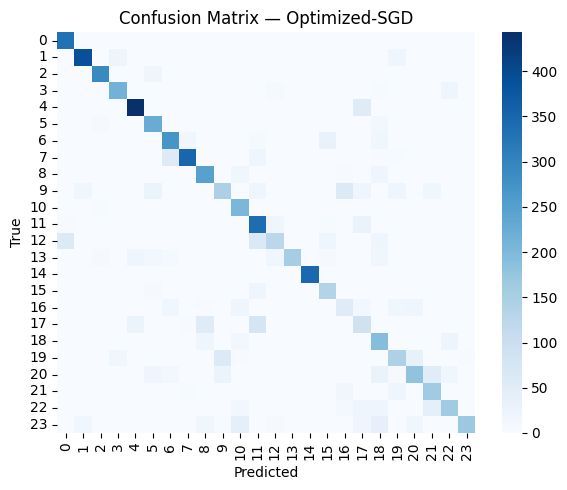

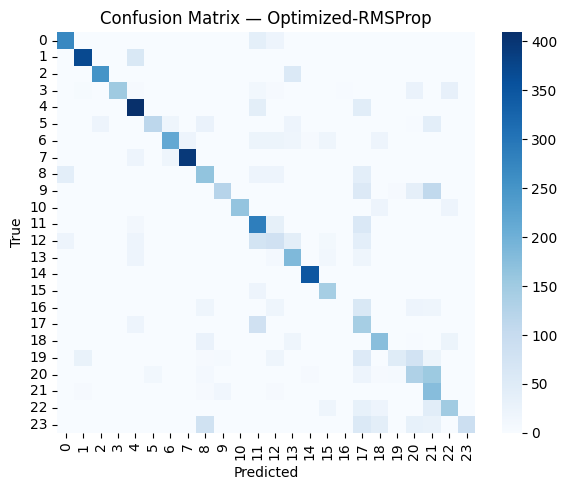

,precision,recall,f1-score,support
0,1.000,0.502,0.668,331.0
1,0.972,0.792,0.872,432.0
2,0.384,1.000,0.555,310.0
3,0.938,0.433,0.592,245.0
4,0.532,0.990,0.692,498.0


In [ ]:
# Evaluate Optimized Models

def log_evaluation(func):
    def wrapper(model, name: str):
        acc, loss = func(model, name)
        print(f"Evaluation complete for {name}")
        return acc, loss
    return wrapper


@log_evaluation  # Refactor: added decorator to separate logging from evaluation logic
def quick_eval(model, name: str):
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{name}: test_acc={acc:.4f} | loss={loss:.4f}")
    return acc, loss


acc_adam, loss_adam = quick_eval(opt_adam, "Optimized-Adam (DO+BN)")
acc_sgd, loss_sgd = quick_eval(opt_sgd, "Optimized-SGD (L2)")
acc_rms, loss_rms = quick_eval(opt_rms, "Optimized-RMSProp (DO)")


# Curves
plot_history(hist_adam, title="Optimized-Adam (Dropout+BatchNorm)")
plot_history(hist_sgd, title="Optimized-SGD (L2)")
plot_history(hist_rms, title="Optimized-RMSProp (Dropout)")


# Predictions + reports
y_pred_adm = opt_adam.predict(X_test, verbose=0).argmax(axis=1)
y_pred_sgd = opt_sgd.predict(X_test, verbose=0).argmax(axis=1)
y_pred_rms = opt_rms.predict(X_test, verbose=0).argmax(axis=1)

plot_confmat(y_test, y_pred_adm, "Confusion Matrix — Optimized-Adam")
plot_confmat(y_test, y_pred_sgd, "Confusion Matrix — Optimized-SGD")
plot_confmat(y_test, y_pred_rms, "Confusion Matrix — Optimized-RMSProp")

rep_adm = classif_report_df(y_test, y_pred_adm)
rep_sgd = classif_report_df(y_test, y_pred_sgd)
rep_rms = classif_report_df(y_test, y_pred_rms)

rep_adm.head()


In [ ]:
# Baseline predictions and report
y_pred_bl = baseline.predict(X_test, verbose=0).argmax(axis=1)
rep_bl = classif_report_df(y_test, y_pred_bl)
rep_bl.head()


,precision,recall,f1-score,support
0,0.863,0.873,0.868,331.0
1,0.667,0.951,0.784,432.0
2,0.883,0.929,0.906,310.0
3,0.623,0.816,0.707,245.0
4,0.721,0.912,0.805,498.0


In [ ]:
summary_sign = (
    pd.DataFrame([
        pick_metrics(rep_bl,  "Baseline Adam 256-128-24"),
        pick_metrics(rep_adm, "Optimized Adam (DO+BN)"),
        pick_metrics(rep_sgd, "Optimized SGD (L2)"),
        pick_metrics(rep_rms, "Optimized RMSProp (DO)"),
    ])
    .round(4)
    .sort_values("Accuracy", ascending=False)
    .reset_index(drop=True)
)

print(summary_sign.to_string(index=False))


                   Model  Accuracy  F1 (macro)  F1 (weighted)
      Optimized SGD (L2)     0.748       0.722          0.743
Baseline Adam 256-128-24     0.670       0.648          0.662
  Optimized RMSProp (DO)     0.639       0.611          0.639
  Optimized Adam (DO+BN)     0.535       0.493          0.516


In [ ]:
# Select best model
accs_sign = [
    ("Baseline Adam 256-128-24", bl_acc, baseline, y_pred_bl),
    ("Optimized Adam (DO+BN)", acc_adam, opt_adam, y_pred_adm),
    ("Optimized SGD (L2)", acc_sgd, opt_sgd, y_pred_sgd),
    ("Optimized RMSProp (DO)", acc_rms, opt_rms, y_pred_rms),
]

best_name, best_acc, best_model, best_pred = sorted(
    accs_sign, key=lambda x: x[1], reverse=True
)[0]

print(f"Best Sign-Language model: {best_name} | test_acc={best_acc:.4f}")


Best Sign-Language model: Optimized SGD (L2) | test_acc=0.7478


Refactored code using lamda

In [ ]:
# Select best model

accs_sign = [
    ("Baseline Adam 256-128-24", bl_acc, baseline, y_pred_bl),
    ("Optimized Adam (DO+BN)", acc_adam, opt_adam, y_pred_adm),
    ("Optimized SGD (L2)", acc_sgd, opt_sgd, y_pred_sgd),
    ("Optimized RMSProp (DO)", acc_rms, opt_rms, y_pred_rms),
]

get_accuracy = lambda record: record[1]  # Refactor: extracted lambda to improve readability

best_name, best_acc, best_model, best_pred = sorted(
    accs_sign, key=get_accuracy, reverse=True
)[0]

print(f"Best Sign-Language model: {best_name} | test_acc={best_acc:.4f}")


Best Sign-Language model: Optimized SGD (L2) | test_acc=0.7478


In [ ]:
# Per-class metrics
labels_all = list(range(num_classes))
names_all = [str(i) for i in labels_all]

best_rep = classification_report(
    y_test,
    best_pred,
    labels=labels_all,
    target_names=names_all,
    output_dict=True,
    zero_division=0,
)

best_df = pd.DataFrame(best_rep).transpose()


In [ ]:
# Hardest classes to classify
per_class = (
    best_df.loc[names_all, ["precision", "recall", "f1-score", "support"]]
    .astype(float)
    .sort_values("f1-score")
)

hardest_sign = per_class.head(5).round(3)

print(hardest_sign.to_string())


    precision  recall  f1-score  support
17      0.360   0.362     0.361    246.0
16      0.361   0.361     0.361    144.0
9       0.613   0.441     0.513    331.0
12      0.702   0.430     0.533    291.0
19      0.620   0.545     0.580    266.0


## Extra Credit: Additional Dataset (Fashion-MNIST)

Applying the same optimization techniques to Fashion-MNIST dataset for cross-dataset comparison.

In [ ]:
# import dataset
from tensorflow.keras.datasets import fashion_mnist


In [ ]:
# load Fashion-MNIST
(X2_train_img, y2_train), (X2_test_img, y2_test) = fashion_mnist.load_data()
print("train:", X2_train_img.shape, "| test:", X2_test_img.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
train: (60000, 28, 28) | test: (10000, 28, 28)


In [ ]:
# scale to [0,1]
X2_train_img = (X2_train_img / 255.0).astype("float32")
X2_test_img = (X2_test_img / 255.0).astype("float32")


In [ ]:
# flatten to 784
X2_train = X2_train_img.reshape(-1, 784)
X2_test = X2_test_img.reshape(-1, 784)


In [ ]:
# meta info
num_classes2 = int(y2_train.max() + 1)

print("pixel range:", float(X2_train_img.min()), "→", float(X2_train_img.max()))
print("num_classes2:", num_classes2)
print("X2_train:", X2_train.shape, "| X2_test:", X2_test.shape)


pixel range: 0.0 → 1.0
num_classes2: 10
X2_train: (60000, 784) | X2_test: (10000, 784)


In [ ]:
# baseline MLP
baseline_fm = Sequential(
    [
        Dense(256, activation="relu", input_shape=(784,)),
        Dense(128, activation="relu"),
        Dense(num_classes2, activation="softmax"),
    ]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# compile
baseline_fm.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
baseline_fm.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train
hist_fm_bl = baseline_fm.fit(
    X2_train,
    y2_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7546 - loss: 0.7103 - val_accuracy: 0.8492 - val_loss: 0.4321
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8610 - loss: 0.3936 - val_accuracy: 0.8723 - val_loss: 0.3676
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8768 - loss: 0.3434 - val_accuracy: 0.8767 - val_loss: 0.3432
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8856 - loss: 0.3147 - val_accuracy: 0.8826 - val_loss: 0.3301
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8942 - loss: 0.2921 - val_accuracy: 0.8825 - val_loss: 0.3243


In [ ]:
# evaluation
fm_bl_loss, fm_bl_acc = baseline_fm.evaluate(X2_test, y2_test, verbose=0)
print(f"fm baseline → acc={fm_bl_acc:.4f} | loss={fm_bl_loss:.4f}")


fm baseline → acc=0.8709 | loss=0.3481


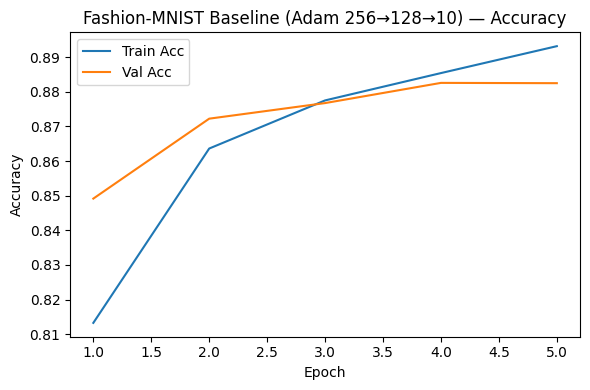

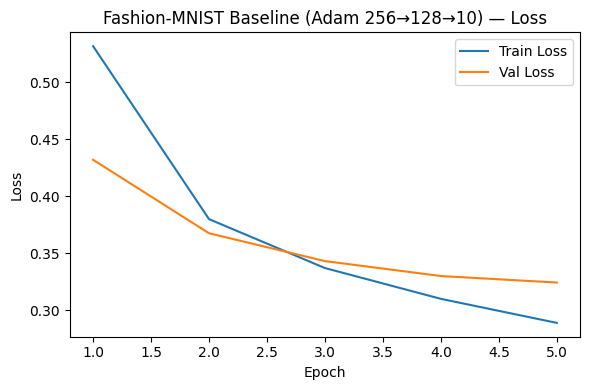

In [ ]:
# plots
plot_history(hist_fm_bl, title="Fashion-MNIST Baseline (Adam 256→128→10)")


In [ ]:
# preds
y2_pred_bl = baseline_fm.predict(X2_test, verbose=0).argmax(axis=1)


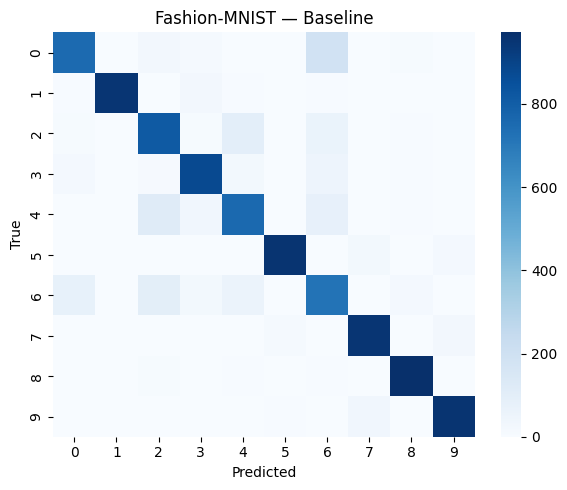

In [ ]:
# confusion matrix
plot_confmat(y2_test, y2_pred_bl, title="Fashion-MNIST — Baseline")


In [ ]:
# report
rep_fm_bl = classif_report_df(y2_test, y2_pred_bl)
rep_fm_bl.head()


,precision,recall,f1-score,support
0,0.864,0.753,0.804,1000.0
1,0.995,0.953,0.973,1000.0
2,0.750,0.816,0.782,1000.0
3,0.882,0.878,0.880,1000.0
4,0.799,0.758,0.778,1000.0


In [ ]:
# build fm mlp layers
def build_mlp_fm(
    optimizer_name: str = "adam",
    use_dropout: bool = False,
    use_bn: bool = False,
    use_l2: bool = False,
    l2_val: float = 1e-3,
    num_classes: int = 10,
):
    reg = regularizers.l2(l2_val) if use_l2 else None

    layers = [Dense(512, activation="relu", kernel_regularizer=reg, input_shape=(784,))]
    if use_bn:
        layers.append(BatchNormalization())
    if use_dropout:
        layers.append(Dropout(0.3))

    layers.append(Dense(256, activation="relu", kernel_regularizer=reg))
    if use_bn:
        layers.append(BatchNormalization())
    if use_dropout:
        layers.append(Dropout(0.3))

    layers.append(Dense(num_classes, activation="softmax"))

    # Instantiate and compile the model
    return compile_fm_mlp(layers, optimizer_name)

In [ ]:
# compile fm mlp
def compile_fm_mlp(layers, optimizer_name: str = "adam"):
    # choose optimizer
    opt = (
        optimizers.Adam(learning_rate=0.001)
        if optimizer_name.lower() == "adam"
        else optimizers.SGD(
            learning_rate=0.01,
            momentum=0.9,
            nesterov=True,
        )
        if optimizer_name.lower() == "sgd"
        else optimizers.RMSprop(learning_rate=0.001)
    )

    model = Sequential(layers)
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [ ]:
#Train all 3 optimized models
EPOCHS_FM = 10
BATCH_FM = 128
VAL_FM = 0.2

# A) Adam + BatchNorm + Dropout
fm_adam = build_mlp_fm("adam", use_dropout=True, use_bn=True)
hist_fm_adam = fm_adam.fit(
    X2_train,
    y2_train,
    epochs=EPOCHS_FM,
    batch_size=BATCH_FM,
    validation_split=VAL_FM,
    verbose=1,
)

# B) SGD + L2
fm_sgd = build_mlp_fm("sgd", use_dropout=False, use_bn=False, use_l2=True)
hist_fm_sgd = fm_sgd.fit(
    X2_train,
    y2_train,
    epochs=EPOCHS_FM,
    batch_size=BATCH_FM,
    validation_split=VAL_FM,
    verbose=1,
)

# C) RMSProp + Dropout
fm_rms = build_mlp_fm("rmsprop", use_dropout=True, use_bn=False)
hist_fm_rms = fm_rms.fit(
    X2_train,
    y2_train,
    epochs=EPOCHS_FM,
    batch_size=BATCH_FM,
    validation_split=VAL_FM,
    verbose=1,
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7622 - loss: 0.6911 - val_accuracy: 0.8397 - val_loss: 0.4365
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8431 - loss: 0.4326 - val_accuracy: 0.8413 - val_loss: 0.4176
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8544 - loss: 0.3946 - val_accuracy: 0.8403 - val_loss: 0.4186
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8660 - loss: 0.3677 - val_accuracy: 0.8617 - val_loss: 0.3818
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8702 - loss: 0.3521 - val_accuracy: 0.8624 - val_loss: 0.3548
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8741 - loss: 0.3416 - val_accuracy: 0.8710 - val_loss: 0.3438
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8777 - loss: 0.3339 - val_accuracy: 0.8621 - val_loss: 0.3629
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8784 - loss: 0.3280 - val_accuracy: 0.

Implement new design pattern

In [ ]:
learning_rates = [0.001, 0.0005]
l2_values = [1e-3, 1e-4]

results_fm = []

for lr in learning_rates:
    for l2_val in l2_values:
        fm_sgd = build_mlp_fm(
            "sgd",
            use_dropout=False,
            use_bn=False,
            use_l2=True,
            l2_val=l2_val,
        )

        fm_sgd.optimizer.learning_rate.assign(lr)

        fm_sgd.fit(
            X2_train,
            y2_train,
            epochs=EPOCHS_FM,
            batch_size=BATCH_FM,
            validation_split=VAL_FM,
            verbose=0,
        )

        loss, acc = fm_sgd.evaluate(X2_test, y2_test, verbose=0)

        results_fm.append({
            "learning_rate": lr,
            "l2": l2_val,
            "accuracy": acc,
        })


Refactored Code — Hyperparameter Tuning

FM Optimized-Adam (BN+DO): test_acc=0.8747 | loss=0.3500
FM Optimized-SGD (L2): test_acc=0.8679 | loss=0.6395
FM Optimized-RMSProp (DO): test_acc=0.8708 | loss=0.3628


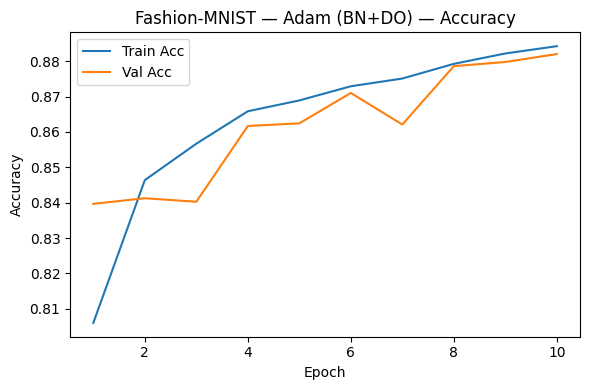

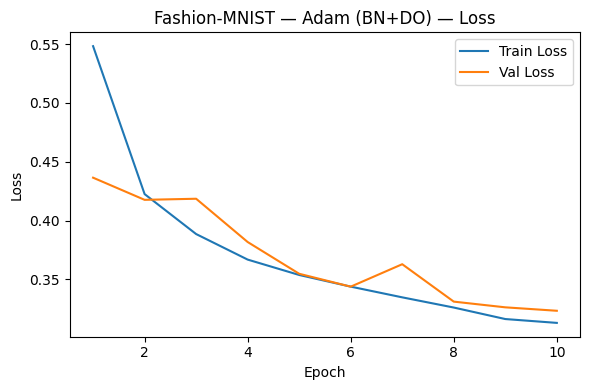

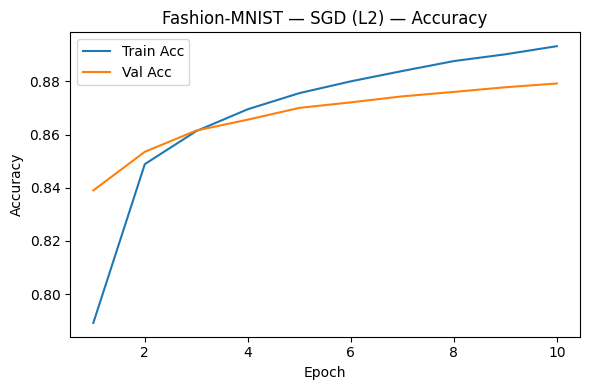

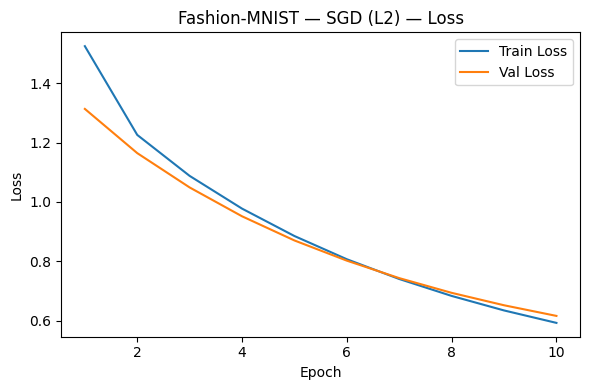

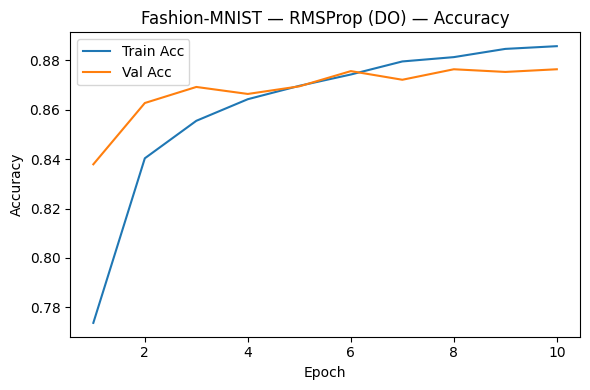

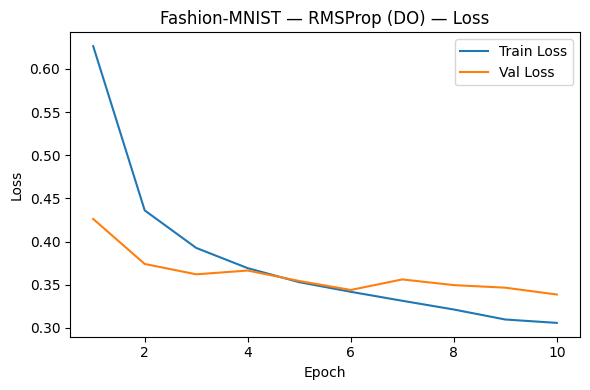

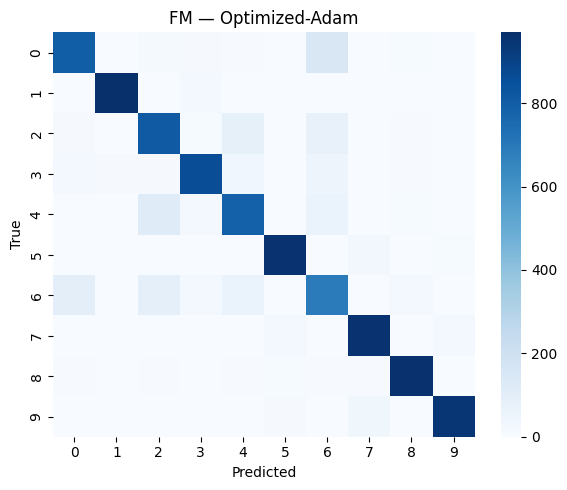

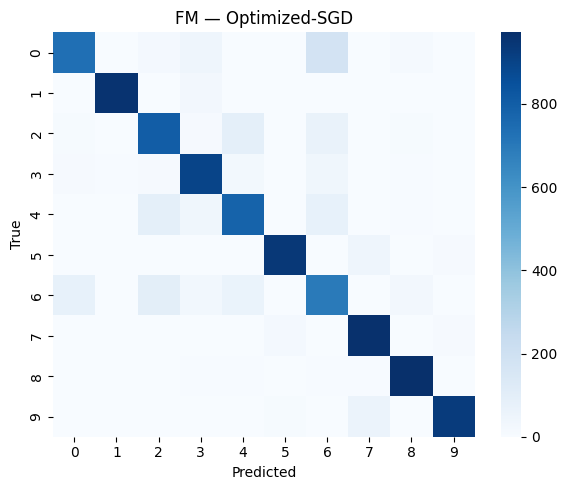

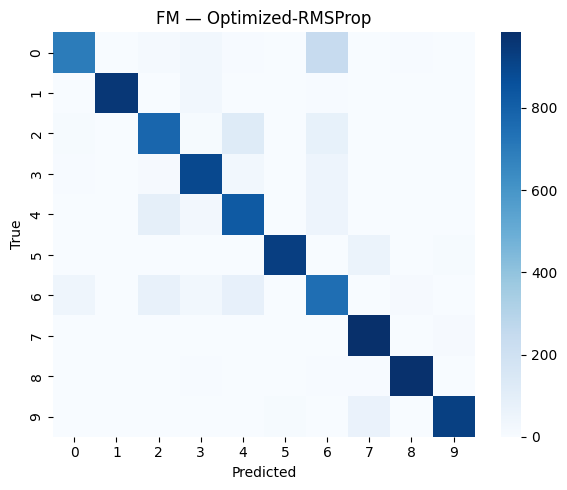

In [ ]:
# Evaluate Optimized Fashion-MNIST Models
def quick_eval_fm(name, model):
    loss, acc = model.evaluate(X2_test, y2_test, verbose=0)
    print(f"{name}: test_acc={acc:.4f} | loss={loss:.4f}")
    return acc, loss

acc_fm_adam, loss_fm_adam = quick_eval_fm("FM Optimized-Adam (BN+DO)", fm_adam)
acc_fm_sgd,  loss_fm_sgd  = quick_eval_fm("FM Optimized-SGD (L2)", fm_sgd)
acc_fm_rms,  loss_fm_rms  = quick_eval_fm("FM Optimized-RMSProp (DO)", fm_rms)

# Curves
plot_history(hist_fm_adam, "Fashion-MNIST — Adam (BN+DO)")
plot_history(hist_fm_sgd, "Fashion-MNIST — SGD (L2)")
plot_history(hist_fm_rms, "Fashion-MNIST — RMSProp (DO)")

# Predictions + reports
y2_pred_adam = fm_adam.predict(X2_test, verbose=0).argmax(axis=1)
y2_pred_sgd  = fm_sgd.predict(X2_test, verbose=0).argmax(axis=1)
y2_pred_rms  = fm_rms.predict(X2_test, verbose=0).argmax(axis=1)

plot_confmat(y2_test, y2_pred_adam, "FM — Optimized-Adam")
plot_confmat(y2_test, y2_pred_sgd, "FM — Optimized-SGD")
plot_confmat(y2_test, y2_pred_rms, "FM — Optimized-RMSProp")

rep_fm_adam = classif_report_df(y2_test, y2_pred_adam)
rep_fm_sgd  = classif_report_df(y2_test, y2_pred_sgd)
rep_fm_rms  = classif_report_df(y2_test, y2_pred_rms)


In [ ]:
#Fashion-MNIST Summary Table
def pick_metrics(df, name):
    acc = df.loc["accuracy", "precision"] if "accuracy" in df.index else None
    f1m = df.loc["macro avg", "f1-score"]
    f1w = df.loc["weighted avg", "f1-score"]
    return {"Model": name, "Accuracy": acc, "F1 (macro)": f1m, "F1 (weighted)": f1w}


summary_fm = (
    pd.DataFrame(
        [
            pick_metrics(rep_fm_bl, "FM Baseline (Adam 256→128→10)"),
            pick_metrics(rep_fm_adam, "FM Optimized-Adam (BN+DO)"),
            pick_metrics(rep_fm_sgd, "FM Optimized-SGD (L2)"),
            pick_metrics(rep_fm_rms, "FM Optimized-RMSProp (DO)"),
        ]
    )
    .round(4)
    .sort_values("Accuracy", ascending=False)
    .reset_index(drop=True)
)

summary_fm


,Model,Accuracy,F1 (macro),F1 (weighted)
0,FM Optimized-Adam (BN+DO),0.875,0.875,0.875
1,FM Baseline (Adam 256→128→10),0.871,0.872,0.872
2,FM Optimized-RMSProp (DO),0.871,0.872,0.872
3,FM Optimized-SGD (L2),0.868,0.868,0.868


In [ ]:
# Cross-Dataset Best-Model Comparison

# Best on Sign-Language MNIST
best_sign_map = {
    "Baseline (Adam 256→128→24)": bl_acc,
    "Optimized-Adam (DO+BN)": acc_adam,
    "Optimized-SGD (L2)": acc_sgd,
    "Optimized-RMSProp (DO)": acc_rms,
}
best_sign_name, best_sign_acc = max(best_sign_map.items(), key=lambda kv: kv[1])

# Best on Fashion-MNIST
best_fm_map = {
    "FM Baseline (Adam 256→128→10)": fm_bl_acc,
    "FM Optimized-Adam (BN+DO)": acc_fm_adam,
    "FM Optimized-SGD (L2)": acc_fm_sgd,
    "FM Optimized-RMSProp (DO)": acc_fm_rms,
}
best_fm_name, best_fm_acc = max(best_fm_map.items(), key=lambda kv: kv[1])

compare_df = pd.DataFrame([
    {
        "Dataset": "Sign Language MNIST",
        "Best Model": best_sign_name,
        "Accuracy": round(best_sign_acc, 4),
    },
    {
        "Dataset": "Fashion-MNIST",
        "Best Model": best_fm_name,
        "Accuracy": round(best_fm_acc, 4),
    },
])

print(compare_df.to_string(index=False))


            Dataset                Best Model  Accuracy
Sign Language MNIST        Optimized-SGD (L2)    0.7478
      Fashion-MNIST FM Optimized-Adam (BN+DO)    0.8747


## Reflection
### 1. How did the optimized models compare to the baseline?
Based on the result only one optimized model SGD with L2 regulation sucessfully improved over the base line the other optimized model does not benefith the data set.

### 2. Which optimization method had the biggest impact and why?
The optimized method SGD with L2 regulation has bigest impact because it  increase performace across all the metrics.
### 3. How did the optimizer choice affect performance and learning stability?

SGD with L2 was the most stable and accurate, RMSProp was moderately stable, and Adam with Dropout + BatchNorm was unstable and gave the weakest performance.

### 4. Which classes were hardest to classify and why?
Clases 17,16,9,12 and 19 were the hardest to classsify because they had the lowest f1_score which shows the model often mis predict them and struggle to separate their pattern from other clases.

### 5. What would you change or try next?
I would add more data for the hardest class and use CNN instead of the simple model and tune SGD more

### 6. Are optimizations like Dropout or L2 regularization always beneficial?
No, optimizations like droup out or L2 are not always helpful. Some times they imporve learning , but other times they can hurt performance if the model becomes  tooweak anor stable
### 7. Set yourself a challenge: Can you get one model to exceed 75% test accuracy?
yes wecan get one model exceeed 75% test accuracy by tuning the learning rate and adding more training  examples specialaly for the hardeest clases.
## Ethical Reflection:
Bias in Model Performance: What are the risks if model optimizations disproportionately benefit some classes (e.g., certain signs) but consistently underperform on others? How can we detect and mitigate this kind of model bias?

If some class impove while other remain weak we can say that the model becomes baised, so we can detect this using f1-score and confusion matrix. to deruce the biases we can add more training data, balcnce clases or retraining the weaker classes.


